In [ ]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [ ]:
common_config.figure_journal_basic()

In [ ]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from gprofiler import gprofiler

In [ ]:
adata = pt.dt.mcfarland_2020()
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

We want to query the GDSC scores for the cell line-perturbation combinations in our dataset. We tested annotating either via SangerID, COSMICID, or cell line name. We found that most cell lines are identifeir when using the SangerID.

In [ ]:
cl_metadata = pt.md.CellLine()

cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["SangerModelID"],
)

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset=1,
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset=2,
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

In [ ]:
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

In [ ]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

In [ ]:
def comp_edger(adata_temp, perturbation):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    logfc_df = pd.DataFrame(columns=adata_temp.var_names)
    
    for cell_line in tqdm(adata_temp.obs["SangerModelID"].unique()):
        
        subset = adata_temp[adata_temp.obs["SangerModelID"] == cell_line]
        if subset.n_obs < 20: #Threshold from the McFarland paper
            continue
        if perturbation not in subset.obs["perturbation"].unique():
            continue
        
        edgr = pt.tl.EdgeR(subset, design="~perturbation")
        edgr.fit()
        
        res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", perturbation))
        res_df = res_df[["variable", "log_fc"]]
        res_df = res_df.set_index("variable")
        res_df = res_df.reindex(adata.var_names)
        
        logfc_df.loc[cell_line] = res_df["log_fc"]
    
    with open(f"data/logfc_df_{perturbation}.pkl", "wb") as f:
        pickle.dump(logfc_df, f)
    
    return logfc_df

In [ ]:
#logfc_df_trametinib = comp_edger(adata, "Trametinib")
#logfc_df_trametinib

In [ ]:
def comp_linear_regression(adata_temp, perturbation, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]

    lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    for gene in tqdm(adata.var_names):
        y = logfc_df.loc[cell_lines][gene].values
        y = y[~na_mask]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]
        
    lr_params["-log10(slope_pval)"] = -np.log10(lr_params["slope_pval"])
    lr_params["-log10(intercept_pval)"] = -np.log10(lr_params["intercept_pval"])
    
    return lr_params

In [ ]:
def plot_example_linear_regression(adata_temp, perturbation, gene, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        x=X[:, 1],
        y=y,
        ax=ax,
    )

    sns.regplot(
        x=X[:, 1],
        y=y,
        scatter=False,
        color="red",
        ax=ax,
    )
    
    ax.set_xlabel(f"ln_ic50_GDSC{gdsc_dataset}")
    ax.set_ylabel(f"logfc_{gene}")
    
    plt.savefig(f"figures/linear_regression_{perturbation}_{gene}.pdf", bbox_inches="tight")
    plt.close()

In [ ]:
def volcano_plot(lr_params, perturbation, coeff, pval_threshold=0.05, value_threshold=0.5):
    assert coeff in ["slope", "intercept"]
    
    #Assign color based on p-value and effect size
    lr_params["color"] = "lightblue"
    lr_params.loc[(lr_params[coeff] > value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "red"
    lr_params.loc[(lr_params[coeff] < -value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "blue"
    
    #Define point size: 1 for lightblue, 5 for red/blue
    lr_params["size"] = 1
    lr_params.loc[lr_params["color"].isin(["red", "blue"]), "size"] = 1.1
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=lr_params,
        x=coeff,
        y="-log10({}_pval)".format(coeff),
        hue="color",
        palette={"lightblue": "lightblue", "red": common_config.pt_red, "blue": common_config.pt_blue},
        size="size",
        ax=ax,
    )
    
    sig_genes = lr_params[lr_params["color"].isin(["red", "blue"])].sort_values("-log10({}_pval)".format(coeff), ascending=False)[:5]
    for i, gene in enumerate(sig_genes.index):
        ax.text(sig_genes.loc[gene, coeff], sig_genes.loc[gene, "-log10({}_pval)".format(coeff)], gene, fontsize=8)
        
    ax.get_legend().remove()
    
    plt.savefig(f"figures/volcano_plot_{perturbation}_{coeff}.pdf", bbox_inches="tight")
    plt.show()

In [179]:
def gsea(lr_params, perturbation, coeff, pval_threshold=0.05, value_threshold_up=0.5, value_threshold_down=-0.5, domain="all"):
    assert coeff in ["slope", "intercept"]
    
    genes_up = lr_params[(lr_params[coeff] > value_threshold_up) & (lr_params[f"{coeff}_pval"] < pval_threshold)].index
    genes_down = lr_params[(lr_params[coeff] < value_threshold_down) & (lr_params[f"{coeff}_pval"] < pval_threshold)].index
    print(f"Number of genes UP: {len(genes_up)}, DOWN: {len(genes_down)}")

    results_up = gprofiler(query=genes_up, organism='hsapiens')
    results_down = gprofiler(query=genes_down, organism='hsapiens')
    
    if domain != "all":
        results_up = results_up[results_up["domain"] == domain]
        results_down = results_down[results_down["domain"] == domain]
    
    # Calculate -log10(p-value) for plotting
    results_up["-log10(P value)"] = -1 * results_up["p.value"].apply(np.log10)
    results_down["-log10(P value)"] = -1 * results_down["p.value"].apply(np.log10)
    
    # Only plot top 3 in ascending order
    enrichment_up = results_up.sort_values("-log10(P value)", ascending=True)[:5]
    enrichment_down = results_down.sort_values("-log10(P value)", ascending=True)[:5]
    
    # Plot the GSEA results
    plt.figure(figsize=(4, 6))
    
    plt.barh(enrichment_down["term.name"], enrichment_down["-log10(P value)"], color=common_config.pt_blue, label="Downregulated")
    plt.barh(enrichment_up["term.name"], enrichment_up["-log10(P value)"], color=common_config.pt_red, label="Upregulated")
    
    plt.xlabel("-log10(P value)")
    plt.ylabel("Pathway")
    plt.legend()
    
    plt.savefig(f"figures/gsea_{perturbation}_{coeff}.pdf", bbox_inches="tight")
    
    return results

# Navitoclax (Main Figure)

In [ ]:
#logfc_df_navitoclax = comp_edger(adata, "Navitoclax")
logfc_df_navitoclax = pd.read_pickle("data/logfc_df_Navitoclax.pkl")
logfc_df_navitoclax

In [ ]:
lr_params_navitoclax = comp_linear_regression(adata, "Navitoclax", 2, logfc_df_navitoclax)

In [ ]:
volcano_plot(lr_params_navitoclax, "Navitoclax", "intercept", pval_threshold=0.01, value_threshold=0.25)

In [ ]:
volcano_plot(lr_params_navitoclax, "Navitoclax", "slope", pval_threshold=0.05, value_threshold=0.05)

In [ ]:
lr_params_navitoclax[(lr_params_navitoclax["slope"] < -0.1)] # & (lr_params_navitoclax["-log10(intercept_pval)"] > 15)

In [ ]:
plot_example_linear_regression(adata, "Navitoclax", "SEC61A2", 2, logfc_df_navitoclax)

In [143]:
plot_example_linear_regression(adata, "Navitoclax", "RPS10", 2, logfc_df_navitoclax)

perturbation
control       29143
Navitoclax     9623
Name: count, dtype: int64


Number of genes UP: 62, DOWN: 31


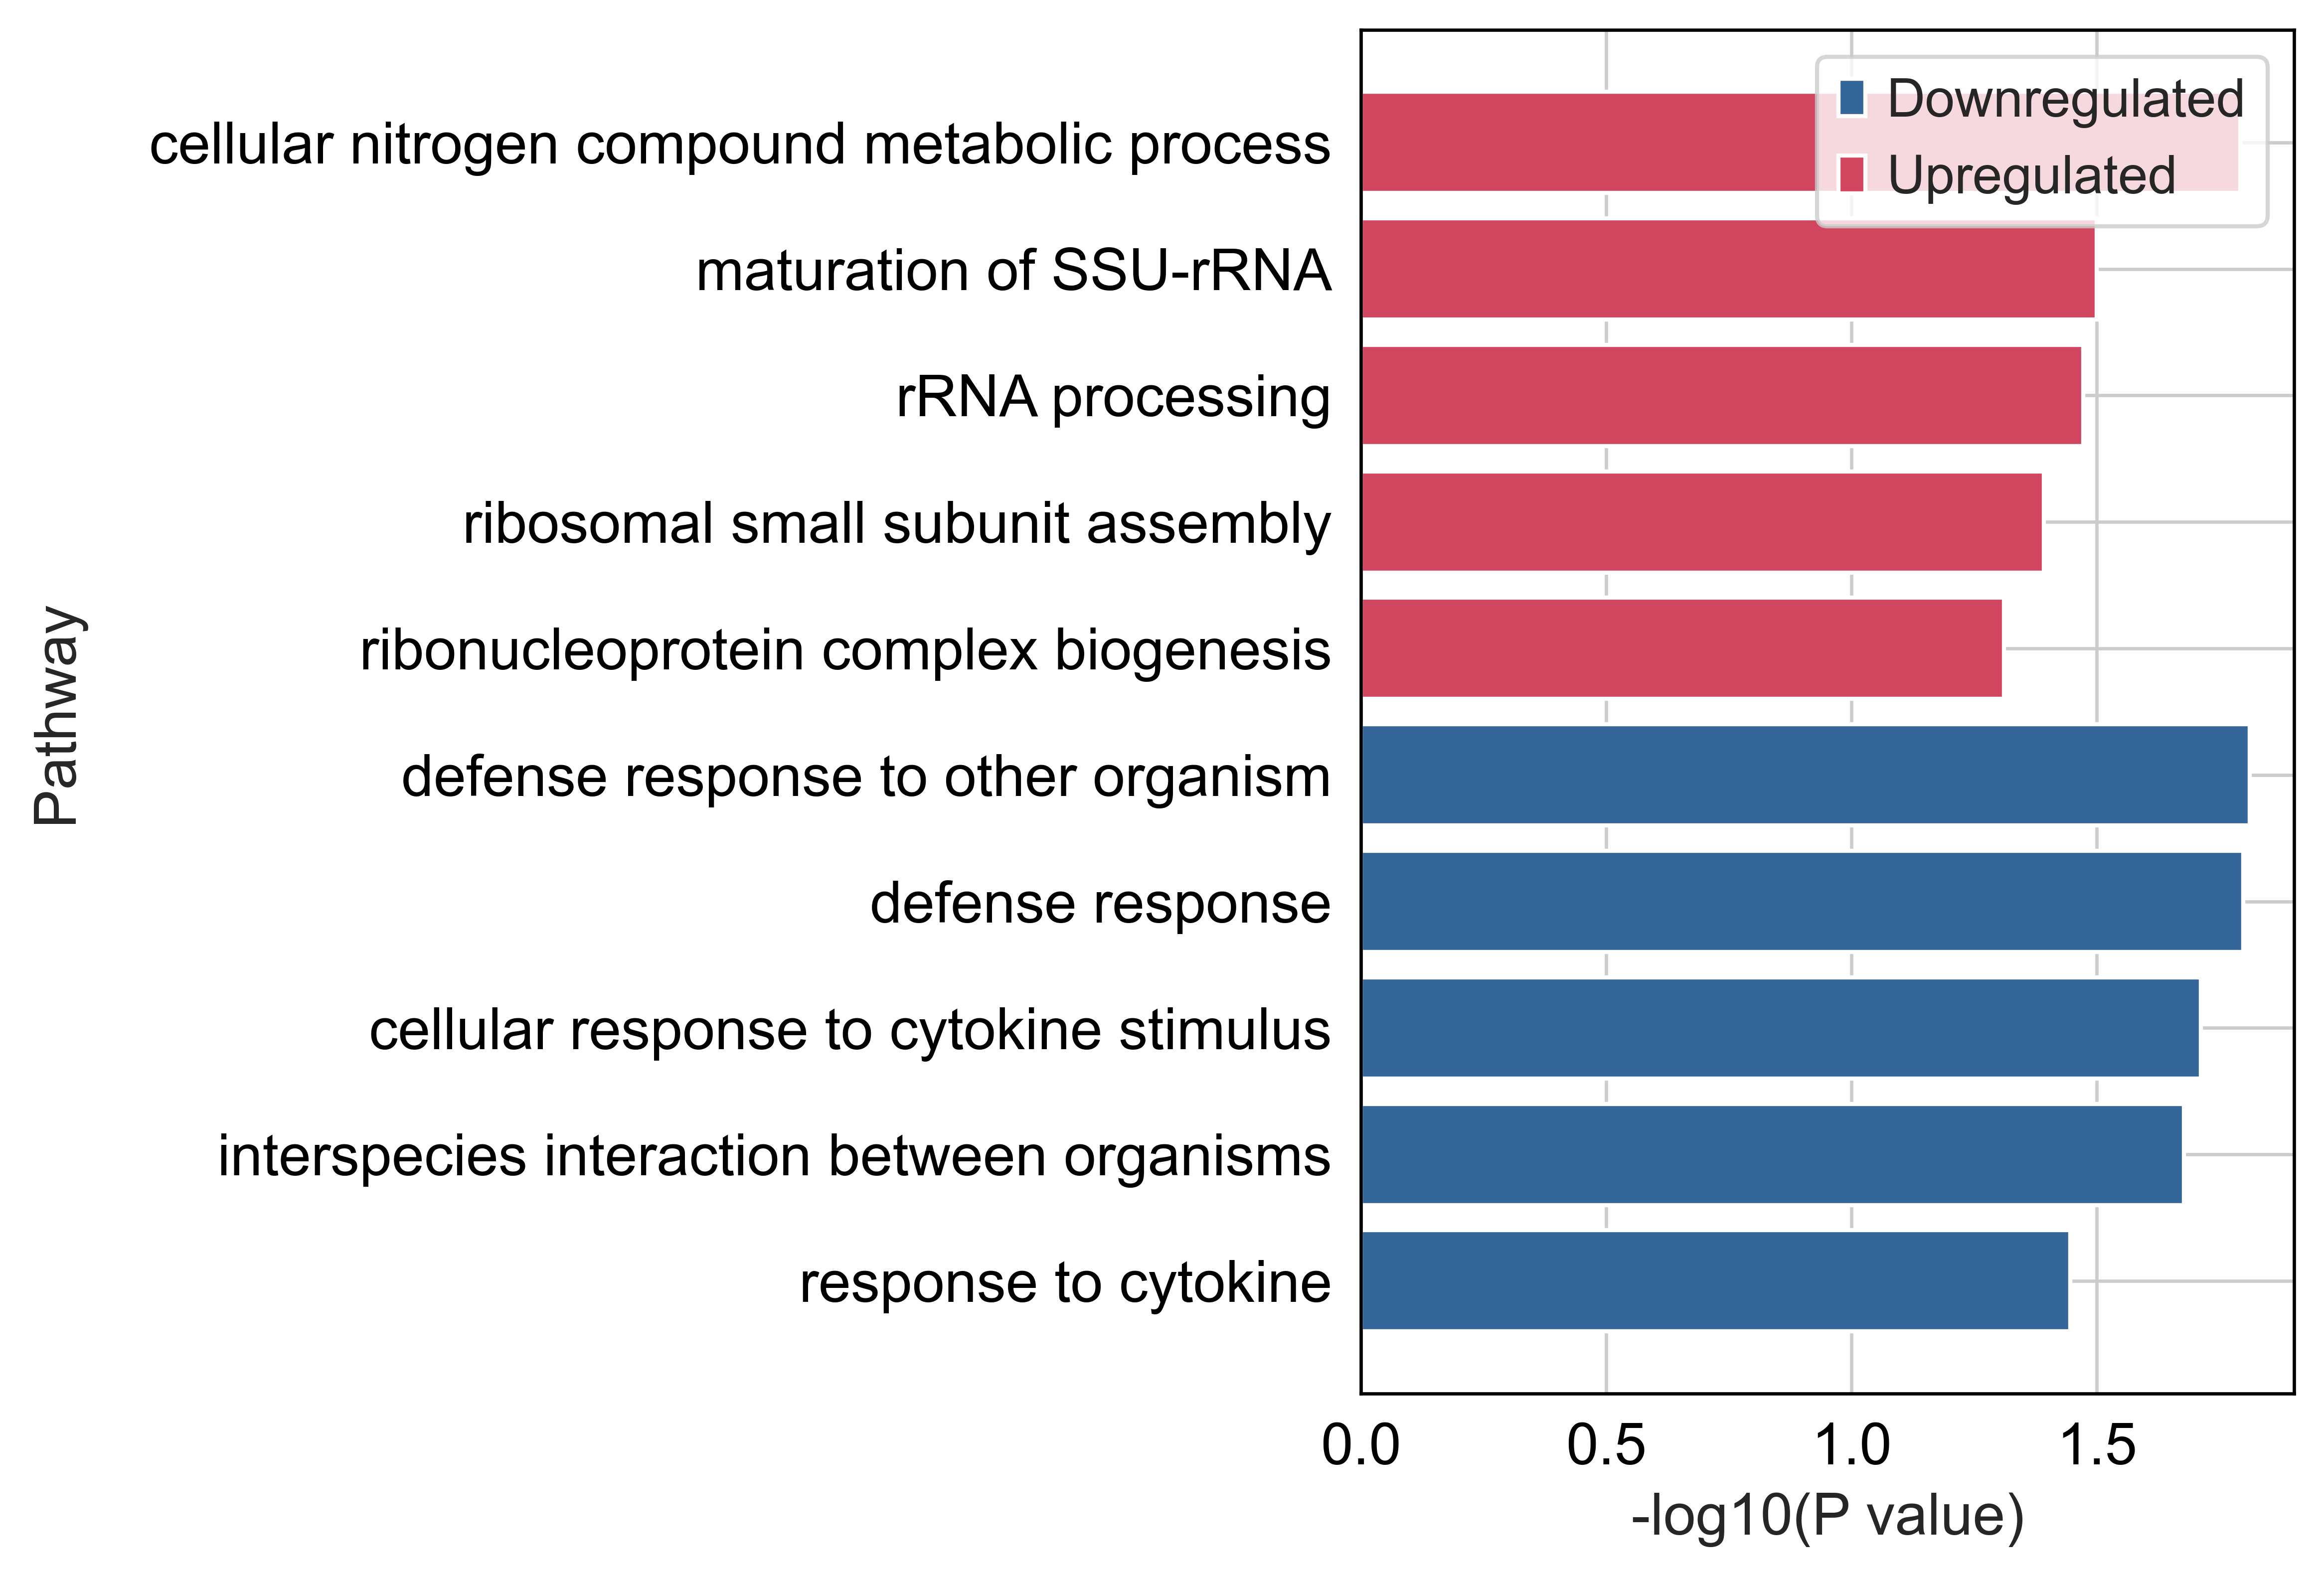

In [180]:
results = gsea(lr_params_navitoclax,
               "Navitoclax",
               "intercept",
               pval_threshold=0.01,
               value_threshold_up=0.25,
               value_threshold_down=-0.5,
               domain="BP",
               )

In [185]:
results = gsea(lr_params_navitoclax,
               "Navitoclax",
               "slope",
               pval_threshold=0.5,
               value_threshold_up=0.07,
               value_threshold_down=-0.001,
               #domain="BP",
               )

Number of genes UP: 88, DOWN: 4270


TypeError: 'NoneType' object is not subscriptable

In [ ]:
results

# Trametinib (Supplementary Figure)

In [ ]:
logfc_df_trametinib = pd.read_pickle("data/logfc_df_trametinib.pkl")
logfc_df_trametinib

In [ ]:
lr_params_trametinib = comp_linear_regression(adata, "Trametinib", 1, logfc_df_navitoclax)
volcano_plot(lr_params_trametinib, "Trametinib", "intercept", pval_threshold=0.01, value_threshold=0.25)

In [ ]:
volcano_plot(lr_params_trametinib, "Trametinib", "slope", pval_threshold=0.01, value_threshold=0.25)

In [ ]:
plot_example_linear_regression(adata, "Trametinib", "RRM2", 1, logfc_df_trametinib)

In [ ]:
lr_params_trametinib = comp_linear_regression(2, logfc_df_trametinib)

In [ ]:
lr_params_trametinib.loc["EGR1"]

# Old: LR with Sklearn

In [ ]:
lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])

lr = LinearRegression()
cell_lines = logfc_df.index
X = adata.obs[["ln_ic50_GDSC1", "SangerModelID"]].drop_duplicates().set_index("SangerModelID").loc[cell_lines]["ln_ic50_GDSC1"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in adata.var_names:
    y = logfc_df[gene].values
    y = y[~na_mask]
    lr.fit(X.reshape(-1, 1), y)
    
    assert len(lr.coef_) == 1
    lr_params.loc[gene] = [gene, lr.coef_[0], lr.intercept_, 